In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from sketch_rnn import Trainer, HParams

#use_wandb = True

hp = HParams()
hp.use_recurrent_dropout=True
hp.r_dropout_prob = 0.1


# hp.augment_stroke_prob = 0.1
# hp.use_random_scale = False
# hp.random_scale_factor = 0.15

# # adding these at same time as augmentation - TODO test separately
hp.use_lr_decay = True
# hp.use_eta = True

hp.dataset_name = 'epoch20240104_trainval09'

hp.max_seq_length = 250


# hp.dataset_name = 'epoch-20231214-trainval'
# hp.dataset_name = 'v2-splice-maxstrokes5'
# hp.dataset_name = 'look_i16'
# hp.dataset_name = 'look_f16'

hp.__dict__()


{'architecture': 'Pytorch-SketchRNN',
 'dataset_source': 'look',
 'dataset_name': 'epoch20240104_trainval09',
 'epochs': 50000,
 'save_every_n_epochs': 100,
 'lr': 0.001,
 'use_lr_decay': True,
 'min_lr': 1e-05,
 'lr_decay': 0.9999,
 'use_recurrent_dropout': True,
 'r_dropout_prob': 0.1,
 'use_layer_norm': True,
 'layer_norm_learnable': False,
 'augment_stroke_prob': 0.1,
 'use_random_scale': True,
 'random_scale_factor': 0.15,
 'lstm_impl': 'custom',
 'enc_hidden_size': 256,
 'dec_hidden_size': 512,
 'batch_size': 100,
 'd_z': 128,
 'n_distributions': 20,
 'kl_div_loss_weight': 0.5,
 'use_eta': False,
 'eta_min': 0.01,
 'eta_R': 0.99995,
 'grad_clip': 1.0,
 'temperature': 0.4,
 'max_seq_length': 250}

In [ ]:
from sketch_rnn import Trainer, HParams

# hp = HParams()
# hp.learning_rate = 1e-3

trainer = Trainer(hp=hp, use_wandb=False, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

RUN_ID: 0797009

HYPERPARAMETERS:

{
  "architecture": "Pytorch-SketchRNN",
  "dataset_source": "look",
  "dataset_name": "epoch20240104_trainval09",
  "epochs": 50000,
  "save_every_n_epochs": 100,
  "lr": 0.001,
  "use_lr_decay": true,
  "min_lr": 1e-05,
  "lr_decay": 0.9999,
  "use_recurrent_dropout": true,
  "r_dropout_prob": 0.1,
  "use_layer_norm": true,
  "layer_norm_learnable": false,
  "augment_stroke_prob": 0.1,
  "use_random_scale": true,
  "random_scale_factor": 0.15,
  "lstm_impl": "custom",
  "enc_hidden_size": 256,
  "dec_hidden_size": 512,
  "batch_size": 100,
  "d_z": 128,
  "n_distributions": 20,
  "kl_div_loss_weight": 0.5,
  "use_eta": false,
  "eta_min": 0.01,
  "eta_R": 0.99995,
  "grad_clip": 1.0,
  "temperature": 0.4,
  "max_seq_length": 250
}


finished filtering - len(dataset) = 2100, len(data) = 2100
finished filtering - len(dataset) = 337, len(data) = 337


In [ ]:
trainer.run_id = '24mzu9rc'
trainer.run_dir = trainer.models_dir / trainer.run_id

In [ ]:
trainer.load(epoch=1400)

In [ ]:
trainer.sample(epoch=301, display=True)

([PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0009_orig.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0111_orig.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0278_orig.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0322_orig.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0324_orig.png')],
 [PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0009_decoded.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0111_decoded.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0278_decoded.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0322_decoded.png'),
  PosixPath('models/24mzu9rc/runid-24mzu9rc_epoch-00301_sample-0324_decoded.png')])

In [ ]:
valid_idxs = trainer.valid_idxs
valid_dataset = trainer.valid_dataset
sampler = trainer.sampler

In [ ]:
data2, mask2 = valid_dataset[valid_idxs[2]]
data3, mask3 = valid_dataset[valid_idxs[3]]

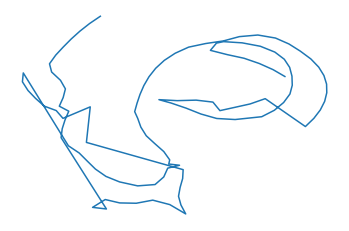

In [ ]:
sampler.plot(data2[1:])

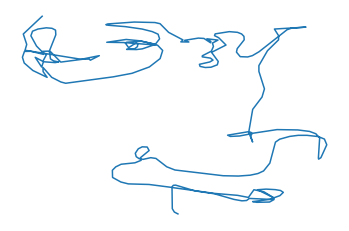

In [ ]:
sampler.plot(data3[1:])

In [ ]:
data2.unsqueeze(1).shape

torch.Size([252, 1, 5])

In [ ]:
with torch.no_grad():
    z2, _, _ = trainer.encoder(data2.unsqueeze(1))
    z3, _, _ = trainer.encoder(data3.unsqueeze(1))

In [ ]:
z2.shape

torch.Size([1, 128])

In [ ]:
z2.unsqueeze(0).shape

torch.Size([1, 1, 128])

In [ ]:
""" [PyTorch implementation of spherical linear interpolation](https://gist.github.com/Birch-san/230ac46f99ec411ed5907b0a3d728efa) """
from torch import FloatTensor, LongTensor, Tensor, Size, lerp, zeros_like
from torch.linalg import norm

# adapted to PyTorch from:
# https://gist.github.com/dvschultz/3af50c40df002da3b751efab1daddf2c
# most of the extra complexity is to support:
# - many-dimensional vectors
# - v0 or v1 with last dim all zeroes, or v0 ~colinear with v1
#   - falls back to lerp()
#   - conditional logic implemented with parallelism rather than Python loops
# - many-dimensional tensor for t
#   - you can ask for batches of slerp outputs by making t more-dimensional than the vectors
#   -   slerp(
#         v0:   torch.Size([2,3]),
#         v1:   torch.Size([2,3]),
#         t:  torch.Size([4,1,1]), 
#       )
#   - this makes it interface-compatible with lerp()
def slerp(v0, v1, t, DOT_THRESHOLD=0.9995):
  '''
  Spherical linear interpolation
  Args:
    v0: Starting vector
    v1: Final vector
    t: Float value between 0.0 and 1.0
    DOT_THRESHOLD: Threshold for considering the two vectors as
                            colinear. Not recommended to alter this.
  Returns:
      Interpolation vector between v0 and v1
  '''
  assert v0.shape == v1.shape, "shapes of v0 and v1 must match"

  # Normalize the vectors to get the directions and angles
  v0_norm: FloatTensor = norm(v0, dim=-1)
  v1_norm: FloatTensor = norm(v1, dim=-1)

  v0_normed: FloatTensor = v0 / v0_norm.unsqueeze(-1)
  v1_normed: FloatTensor = v1 / v1_norm.unsqueeze(-1)

  # Dot product with the normalized vectors
  dot: FloatTensor = (v0_normed * v1_normed).sum(-1)
  dot_mag: FloatTensor = dot.abs()

  # if dp is NaN, it's because the v0 or v1 row was filled with 0s
  # If absolute value of dot product is almost 1, vectors are ~colinear, so use lerp
  gotta_lerp: LongTensor = dot_mag.isnan() | (dot_mag > DOT_THRESHOLD)
  can_slerp: LongTensor = ~gotta_lerp

  t_batch_dim_count: int = max(0, t.dim()-v0.dim()) if isinstance(t, Tensor) else 0
  t_batch_dims: Size = t.shape[:t_batch_dim_count] if isinstance(t, Tensor) else Size([])
  out: FloatTensor = zeros_like(v0.expand(*t_batch_dims, *[-1]*v0.dim()))

  # if no elements are lerpable, our vectors become 0-dimensional, preventing broadcasting
  if gotta_lerp.any():
    lerped: FloatTensor = lerp(v0, v1, t)

    out: FloatTensor = lerped.where(gotta_lerp.unsqueeze(-1), out)

  # if no elements are slerpable, our vectors become 0-dimensional, preventing broadcasting
  if can_slerp.any():

    # Calculate initial angle between v0 and v1
    theta_0: FloatTensor = dot.arccos().unsqueeze(-1)
    sin_theta_0: FloatTensor = theta_0.sin()
    # Angle at timestep t
    theta_t: FloatTensor = theta_0 * t
    sin_theta_t: FloatTensor = theta_t.sin()
    # Finish the slerp algorithm
    s0: FloatTensor = (theta_0 - theta_t).sin() / sin_theta_0
    s1: FloatTensor = sin_theta_t / sin_theta_0
    slerped: FloatTensor = s0 * v0 + s1 * v1

    out: FloatTensor = slerped.where(can_slerp.unsqueeze(-1), out)
  
  return out

In [ ]:
slerp(z2, z3, 0)

tensor([[ 0.7827,  0.7086, -0.7425,  0.4669, -1.0254,  2.3590,  1.0030,  0.2738,
          0.7805,  0.5801,  0.0103,  0.9013,  0.3396,  0.8577, -0.6368, -0.8957,
          0.5894, -0.1086,  1.3428, -0.1071, -0.6003, -0.4055, -0.6690,  0.2583,
          0.2705,  1.0663,  0.2420, -1.6233, -0.0745,  1.0967, -1.1854, -0.5509,
          1.1868, -0.1857, -0.8093, -1.7034,  1.3161,  0.1342, -1.0454,  1.0012,
         -0.9898, -0.3468, -1.2686, -0.7524,  1.0658,  0.1384,  0.1721, -1.1198,
          1.3469, -0.7488,  0.5926, -0.1178, -0.1686,  0.1547, -0.6146, -1.3895,
          1.2956,  1.3817, -0.9925, -0.3345,  0.0497,  1.2302,  0.3709,  1.2228,
          0.5886, -0.4715, -0.2841, -0.0313,  0.8806, -0.6602, -0.7123, -0.4913,
          0.7012,  0.6432,  0.0846,  1.4762, -0.1421, -1.9215,  1.3716,  0.2398,
         -0.1423, -0.0664,  1.5730,  1.1177,  0.8059, -0.0395, -0.6244,  0.5727,
         -0.7353, -0.0956, -0.6758,  1.0789,  1.8004, -0.1291,  0.5869, -0.0253,
         -1.5026, -0.6811, -

In [ ]:
slerp(z2, z3, 1)

tensor([[ 0.9710,  0.4806, -1.8958, -0.3833,  1.6092,  2.1806, -0.6073,  0.6487,
         -1.3068, -0.1375, -1.4526,  0.6167, -0.1780,  0.0847, -0.7644, -0.3186,
         -0.8262, -0.7088,  0.2408,  0.3129, -0.0839,  1.0158, -1.4780,  0.5545,
         -0.3593,  0.6737,  0.7924, -0.5892,  1.0271,  0.1488, -1.2235,  1.5290,
         -1.1057, -0.0088, -1.1886,  1.0508,  0.0590, -0.3424, -1.4482, -1.2145,
          0.4040,  0.5932,  0.5575,  0.4422, -0.0393, -0.4246,  0.6070, -0.5190,
         -0.2788, -0.6990, -1.2311,  0.2346, -0.5109,  0.3312, -1.5622,  0.7915,
          0.7322, -1.3580, -0.0468, -1.8224,  0.1478,  0.2128,  0.7287, -0.3246,
          0.4469, -0.5282, -0.1056, -0.2822,  1.4007, -0.6527,  1.2771,  0.3289,
          1.7268,  0.0681, -0.0994,  1.3111, -0.3651, -0.7345, -0.8294,  0.3715,
         -0.9765,  0.5427,  0.2364,  0.1852, -0.8248, -1.1068, -0.1085,  0.9014,
         -0.0284, -0.0246,  0.7728,  0.0761, -1.3665, -0.2311,  0.5076,  0.6913,
          0.0084,  1.4494,  

In [ ]:

slerp(z2, z3, 0.9)

tensor([[ 1.0695,  0.5778, -1.9695, -0.3051,  1.4219,  2.4925, -0.4436,  0.6769,
         -1.1626, -0.0472, -1.4216,  0.7403, -0.1232,  0.2124, -0.8450, -0.4473,
         -0.7206, -0.7108,  0.4386,  0.2904, -0.1728,  0.9341, -1.5491,  0.5823,
         -0.3112,  0.8210,  0.8129, -0.8223,  0.9951,  0.3113, -1.3777,  1.4150,
         -0.9042, -0.0366, -1.2867,  0.7725,  0.2564, -0.3152, -1.5767, -1.0389,
          0.2464,  0.5289,  0.3547,  0.3197,  0.1223, -0.3952,  0.6207, -0.6775,
         -0.0699, -0.7978, -1.1167,  0.2120, -0.5260,  0.3479, -1.6234,  0.5658,
          0.9129, -1.1220, -0.1957, -1.8360,  0.1523,  0.3942,  0.7699, -0.1335,
          0.5267, -0.5887, -0.1464, -0.2812,  1.5053, -0.7391,  1.1438,  0.2481,
          1.7977,  0.1638, -0.0846,  1.5074, -0.3792, -1.0097, -0.6057,  0.4002,
         -0.9782,  0.5217,  0.4691,  0.3502, -0.6865, -1.0904, -0.2006,  0.9696,
         -0.1388, -0.0385,  0.6551,  0.2374, -1.0671, -0.2459,  0.5860,  0.6735,
         -0.2186,  1.3173,  

In [ ]:
import numpy as np

for t in np.linspace(0, 1, 30):
    print(t)

0.0
0.034482758620689655
0.06896551724137931
0.10344827586206896
0.13793103448275862
0.1724137931034483
0.20689655172413793
0.24137931034482757
0.27586206896551724
0.3103448275862069
0.3448275862068966
0.3793103448275862
0.41379310344827586
0.4482758620689655
0.48275862068965514
0.5172413793103449
0.5517241379310345
0.5862068965517241
0.6206896551724138
0.6551724137931034
0.6896551724137931
0.7241379310344828
0.7586206896551724
0.7931034482758621
0.8275862068965517
0.8620689655172413
0.896551724137931
0.9310344827586207
0.9655172413793103
1.0


In [ ]:
decoder = trainer.decoder
temperature = 0.1

def decode(z, data, temperature=0.4, longest_seq_len=252):
    s = data.new_tensor([0, 0, 1, 0, 0])
    seq = [s]
    # Initial decoder is `None`.
    # The decoder will initialize it to $[h_0; c_0] = \tanh(W_{z}z + b_z)$
    state = None
    
    # We don't need gradients
    with torch.no_grad():
        # Sample $N_{max}$ strokes
        for i in range(longest_seq_len):
            # $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$ is the input to the decoder
            data = torch.cat([s.view(1, 1, -1), z.unsqueeze(0)], 2)
            # Get $\Pi$, $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$,
            # $q$ and the next state from the decoder
            dist, q_logits, state = decoder(data, z, state)
            # Sample a stroke
            s = sampler._sample_step(dist, q_logits, temperature)
            # Add the new stroke to the sequence of strokes
            seq.append(s)
            # Stop sampling if $p_3 = 1$. This indicates that sketching has stopped
            if s[4] == 1:
                break
    
    # Create a PyTorch tensor of the sequence of strokes
    seq = torch.stack(seq)
    return seq

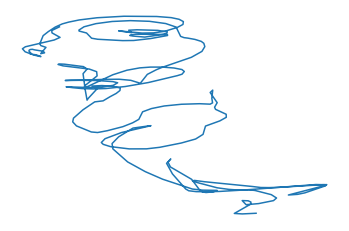

In [ ]:
seq = decode(z3, data2, temperature=0.1, longest_seq_len=256)
sampler.plot(seq[2:])

In [ ]:
import os
import numpy as np




idx1 = valid_idxs[2]
idx2 = valid_idxs[3]
## todo populate z2, z3, data2

temp = 0.05
longest_seq_len = 156
interp_steps = 100

interp_name = f"from{idx1:04d}-to{idx2:04d}_steps{interp_steps}_temp{temp:.02f}_len{interp_steps}"

parent_dir = 'out/interpolations'
interp_dir = os.path.join(parent_dir, interp_name)

os.makedirs(interp_dir, exist_ok=True)

all_seqs = []
all_files = []
for t in np.linspace(0, 1, interp_steps):
    frame_fname = os.path.join(interp_dir, f"{t:04f}.png")
    seq = decode(slerp(z2, z3, t), data2, temperature=temp, longest_seq_len=longest_seq_len)
    sampler.plot(seq[2:], frame_fname)
    all_seqs.append(seq)
    all_files.append(frame_fname)

In [ ]:
from glob import glob

all_files = sorted(glob(f"{interp_dir}/*.png"))

In [ ]:
import base64
import io

from IPython.display import display, HTML
from moviepy.editor import *

interp_video_fname = os.path.join(parent_dir, interp_name + ".mp4")

new_clip = ImageSequenceClip(all_files, fps=10)
new_clip.write_videofile(interp_video_fname)

def show_video(fname="video.mp4"):
    """
    create_animation(strokes, fname="video.mp4", lw=2)
    show_video("video.mp4")
    """
    video = io.open(fname, "r+b").read()
    encoded = base64.b64encode(video)
    html_data = f"""<video alt="video" autoplay loop>
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>"""
    display(HTML(data=html_data))


show_video(interp_video_fname)


Moviepy - Building video out/interpolations/from0278-to0009_steps100_temp0.05_len100.mp4.
Moviepy - Writing video out/interpolations/from0278-to0009_steps100_temp0.05_len100.mp4



Moviepy - Done !
Moviepy - video ready out/interpolations/from0278-to0009_steps100_temp0.05_len100.mp4


In [ ]:
from singleline_stroke3.display import *
from singleline_stroke3.transforms import *

In [ ]:
seq = all_seqs[8][1:]

In [ ]:
seq[:,2] = torch.zeros_like(seq[:,0])

In [ ]:
points = deltas_to_points(seq[:,:3])

In [ ]:
bb = BoundingBox.create(points)

rescaled_points = apply_transform(points[:,:2], bb.normalization_xform())
rescaled_points *= 2000
rescaled_points[:,2] = points[:,2]

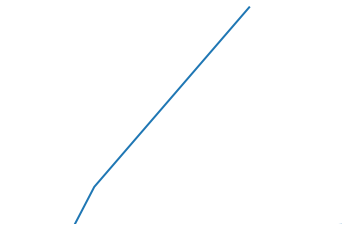

In [ ]:
plot_strokes(points_to_strokes(rescaled_points))

In [ ]:
create_animation?

Signature:
create_animation(
    strokes,
    fname='video.mp4',
    fps=60,
    target_size=200,
    figsz=5,
    lw=2,
    trailing_frames=30,
)
Docstring: <no docstring>
File:      ~/code/_svg/singleline_stroke3/singleline_stroke3/display.py
Type:      function

In [ ]:
create_animation(points_to_strokes(rescaled_points), figsz=8, target_size=2000, lw=1, linecolor="black")

156


In [ ]:
show_video('video.mp4')

## prev sampling experiment

In [ ]:
encoder = trainer.encoder
decoder = trainer.decoder

In [ ]:
train_ds = trainer.train_dataset

In [ ]:
train_ds[0][0]

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 1.9672,  1.0369,  1.0000,  0.0000,  0.0000],
        [-0.5270,  0.6296,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000]])

In [ ]:
sampler = trainer.sampler

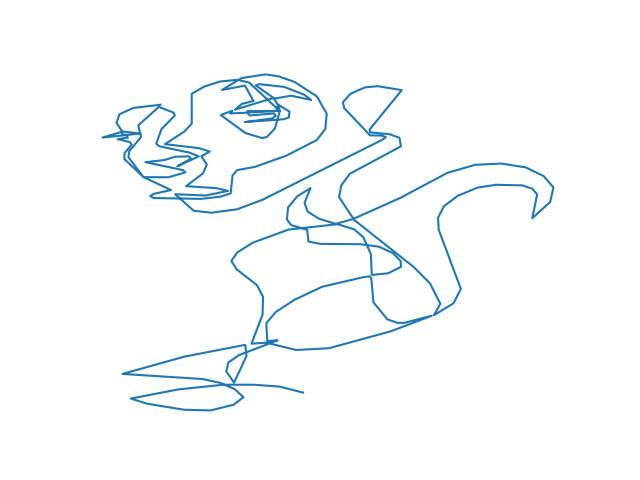

In [ ]:
sampler.plot(train_ds[0][0][2:], 'test.png')

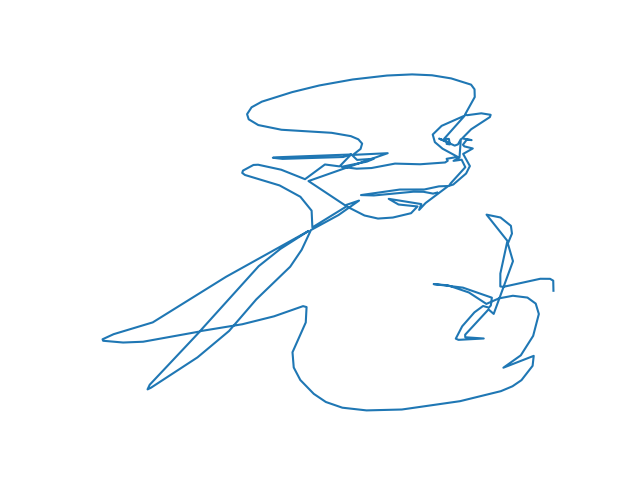

In [ ]:
sampler.plot(train_ds[1][0][2:], 'test.png')

In [ ]:
data = train_ds[0][0].unsqueeze(1)
z, _, _ = encoder(data)

In [ ]:
len(data)

252

In [ ]:
data2 = train_ds[1][0].unsqueeze(1)
z2, _, _ = encoder(data2)
len(data2)

252

In [ ]:
longest_seq_len = len(data)

In [ ]:
z

tensor([[-3.7790e-01,  9.6061e-01, -8.8631e-01, -7.4359e-01,  9.3663e-01,
         -5.8355e-01, -1.1366e+00,  1.2690e-02, -8.0981e-01, -9.0349e-01,
          1.0140e+00,  7.5137e-01,  1.8669e-01, -4.8449e-02,  4.4514e-01,
         -1.0270e+00,  3.2760e-01,  4.6783e-01,  4.3849e-01, -1.0620e-01,
         -1.0188e+00, -1.4944e+00,  6.9765e-01,  1.2396e+00,  1.8711e-01,
         -1.3234e-01,  1.2382e+00,  6.8178e-01, -1.2422e+00,  6.2931e-01,
          1.8722e-01,  2.3228e+00,  1.2171e+00,  3.6234e-01, -2.1343e-01,
         -7.5433e-01, -1.0587e+00,  3.8684e-01, -1.3775e-01, -4.9102e-01,
          1.4384e-01, -4.8146e-01, -3.4073e-01,  1.3074e+00, -1.6965e+00,
          9.2100e-01, -2.0843e-02, -1.0077e+00,  7.4839e-01, -5.1015e-01,
         -1.9975e-01, -3.0582e-01,  4.6869e-01, -6.4902e-01, -5.2377e-02,
         -5.8632e-01, -1.2627e+00,  1.7185e+00, -2.0078e-01, -3.2091e-01,
          1.7947e-02, -1.1325e+00,  3.4101e-01, -1.7139e+00, -2.7426e-01,
         -3.1202e-01, -3.1012e-01,  1.

In [ ]:
z.shape

torch.Size([1, 128])

In [ ]:
temperature = 0.1

def decode(z, data, temperature=0.4, longest_seq_len=252):
    s = data.new_tensor([0, 0, 1, 0, 0])
    seq = [s]
    # Initial decoder is `None`.
    # The decoder will initialize it to $[h_0; c_0] = \tanh(W_{z}z + b_z)$
    state = None
    
    # We don't need gradients
    with torch.no_grad():
        # Sample $N_{max}$ strokes
        for i in range(longest_seq_len):
            # $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$ is the input to the decoder
            data = torch.cat([s.view(1, 1, -1), z.unsqueeze(0)], 2)
            # Get $\Pi$, $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$,
            # $q$ and the next state from the decoder
            dist, q_logits, state = decoder(data, z, state)
            # Sample a stroke
            s = sampler._sample_step(dist, q_logits, temperature)
            # Add the new stroke to the sequence of strokes
            seq.append(s)
            # Stop sampling if $p_3 = 1$. This indicates that sketching has stopped
            if s[4] == 1:
                break
    
    # Create a PyTorch tensor of the sequence of strokes
    seq = torch.stack(seq)
    return seq

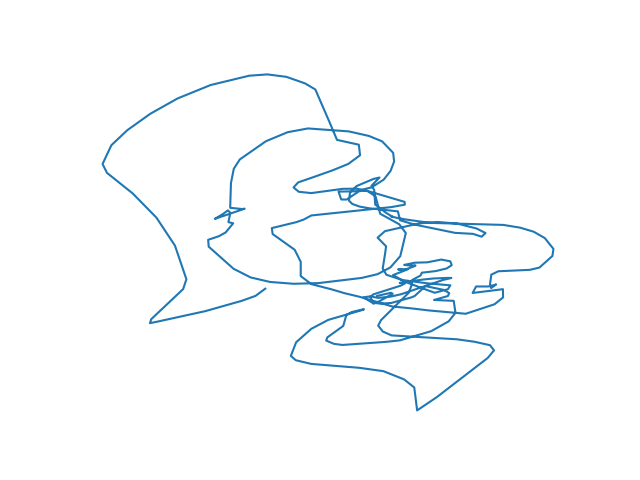

In [ ]:
seq = decode(z2, data2, temperature=0.01, longest_seq_len=longest_seq_len)
sampler.plot(seq[2:], 'test.png')

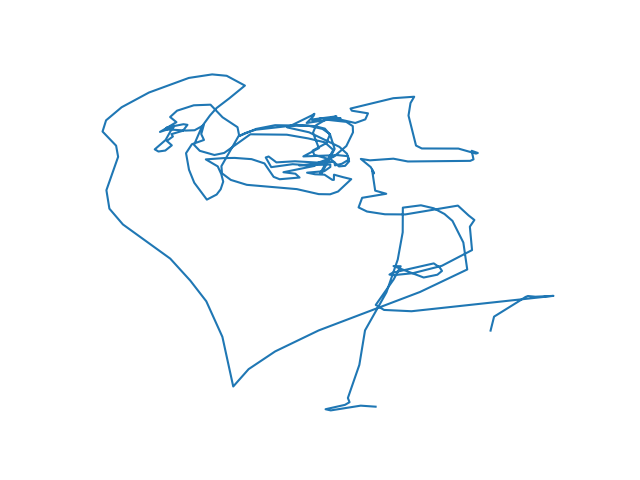

In [ ]:
seq = decode(z2, data2, temperature=0.01, longest_seq_len=longest_seq_len)
sampler.plot(seq[2:], 'test2.png')

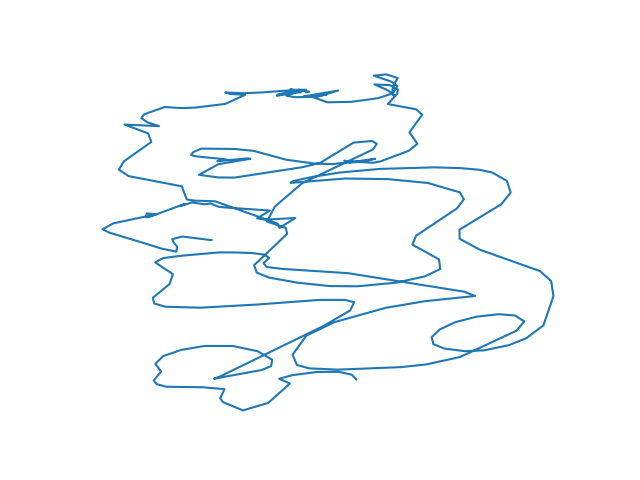

In [ ]:
seq = decode(z2, data2, temperature=0.01, longest_seq_len=longest_seq_len)
sampler.plot(seq[2:], 'test3.png')

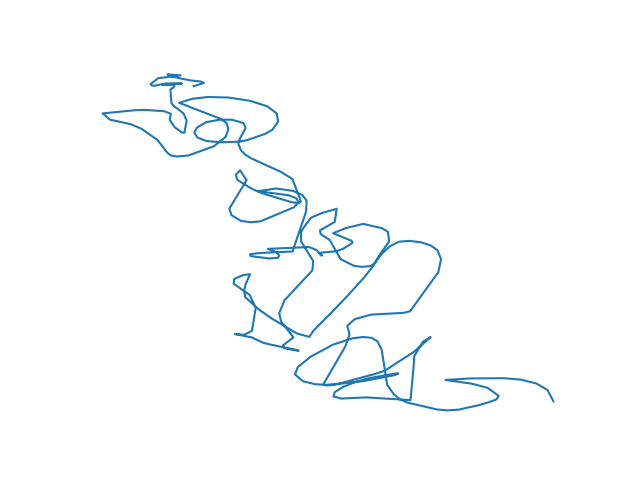

In [ ]:
seq = decode(z, data, temperature=0.01, longest_seq_len=longest_seq_len)
sampler.plot(seq[2:], 'test4.png')

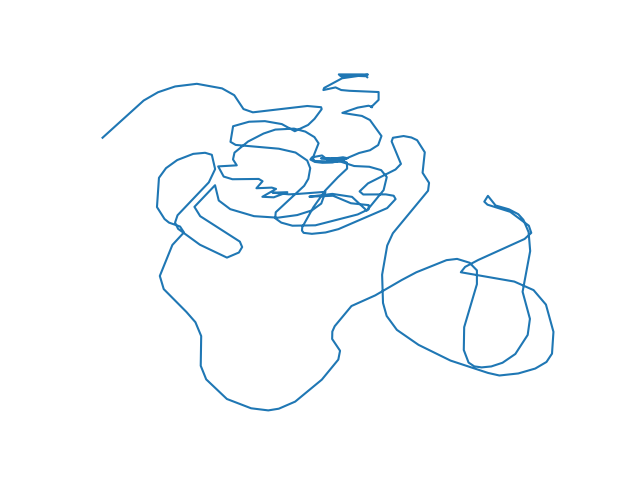

In [ ]:
seq = decode(z, data, temperature=0.01, longest_seq_len=longest_seq_len)
sampler.plot(seq[2:], 'test5.png')